HighTime - Web traffic analysis neural model
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this assignment is to train a simple DNN model to make predictions over web traffic.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt

Let us mimic real traffic data by using normal distribution:

[  7  19  25  41  96 136 192 248 336 406 468 512 519 481 373 334 263 207]


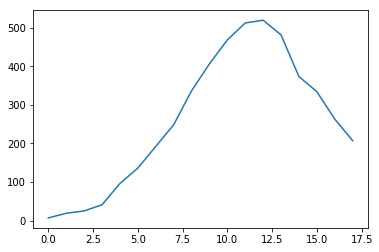

In [2]:
def fake_train(batch_size=24):
  assert batch_size > 0 and batch_size < 25
  normal = np.random.normal(12, 4, 5000)
  train = np.arange(batch_size)

  for i in range(0, batch_size):
    count = 0
    for p in normal:
      if (p >= i and p < i + 1):
        count += 1
    train[i] = count
  return train

example = fake_train(18)
print(example)

plt.plot(range(0, 18), example)
plt.show()

Function to generate a training batch:

In [3]:
class BatchGenerator(object):
  def __init__(self, feature_size, batch_size):
    self._batch_size = batch_size
    self._feature_size = feature_size

  def spit(self):
    labels = fake_train(self._batch_size).reshape([self._batch_size, 1])
    train = np.zeros((self._batch_size, self._feature_size), dtype=np.float32)
    np.fill_diagonal(train, 1)

    return train, labels

Generate valid and test datasets:

In [4]:
feature_size = 24 # 24 hours per day

generator = BatchGenerator(feature_size, 24)

valid_dataset, valid_labels = generator.spit()
test_dataset, test_labels = generator.spit()

np.set_printoptions(formatter={'float': '{0:g}'.format})
for vector, label in list(zip(test_dataset, test_labels)):
  print('data (hour) = %s => %d rps' % (vector, label))

data (hour) = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 8 rps
data (hour) = [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 12 rps
data (hour) = [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 32 rps
data (hour) = [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 55 rps
data (hour) = [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 119 rps
data (hour) = [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 133 rps
data (hour) = [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 226 rps
data (hour) = [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 270 rps
data (hour) = [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 343 rps
data (hour) = [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 411 rps
data (hour) = [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] => 452 rps
data (hour) = [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] => 539 rps
data (hour) = [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] => 503 rps
data (hour) = [0 0 0 0 0 0 0 0

Simple NN Model.

In [5]:
num_labels = 1 # label dimension
num_hidden_nodes = 64
batch_size = 18
learning_rate = 0.5

graph = tf.Graph()
with graph.as_default():
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  X = tf.placeholder(tf.float32, shape=(batch_size, feature_size))
  Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))

  tf_test_dataset = tf.constant(test_dataset)
  predict_data = tf.placeholder(tf.float32, shape=(num_labels, feature_size))

  # Hidden layer variables
  weights1 = tf.Variable(tf.ones([feature_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))

  # Variables.
  weights2 = tf.Variable(tf.ones([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  hidden_layer = tf.nn.relu(tf.matmul(X, weights1) + biases1)
  y = tf.matmul(hidden_layer, weights2) + biases2
  loss = tf.reduce_mean(tf.square(y - Y))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Predictions for the training, test and real data.
  train_prediction = y
  test_prediction_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.matmul(test_prediction_hidden, weights2) + biases2
  prediction_hidden = tf.nn.relu(tf.matmul(predict_data, weights1) + biases1)
  prediction = tf.matmul(prediction_hidden, weights2) + biases2

In [7]:
num_steps = 501
generator = BatchGenerator(feature_size, batch_size)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

session = tf.Session(graph=graph)

with graph.as_default():
  with session.as_default():
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
      batch_data, batch_labels = generator.spit()
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {X : batch_data, Y : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 50 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
  #       print("Validation accuracy: %.1f%%" % accuracy(
  #         valid_prediction.eval(), valid_labels))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 66982.218750
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 50: 30629.103516
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 100: 29926.572266
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 150: 29580.222656
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 200: 29305.445312
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 250: 28798.832031
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 300: 29477.746094
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 350: 29689.320312
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 400: 29171.222656
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 450: 28780.460938
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 500: 28578.212891
Minibatch accuracy: 100.0%
Test accuracy: 100.0%


Let us check it out

In [15]:
to_predict = np.zeros(feature_size)
to_predict[2] = 1
print(to_predict)
data_to_predict = to_predict.reshape(1, feature_size)

with session.as_default():
  print(prediction.eval(feed_dict={predict_data : data_to_predict}))
#   print(weights.eval(), biases.eval())

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[260.056]]
